In [7]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, ngrams
np.random.seed(25)

In [8]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution1D, GlobalMaxPooling1D, GlobalAveragePooling1D,GlobalMaxPool1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, concatenate,Concatenate
from keras.layers.merge import concatenate
from keras.layers.core import Dense, Activation, Dropout
import codecs

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
train.shape

(159571, 8)

In [12]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [13]:
train['comment_text'].iloc[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [15]:
train.isnull().sum(axis=0)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [16]:
types = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

In [17]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


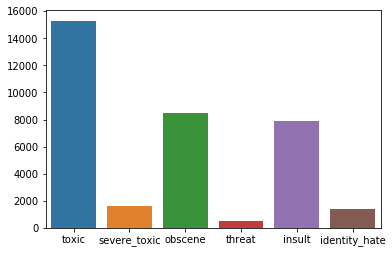

In [18]:
count_list = []
for i in types:
    count_list.append(train[i].sum())
    
sns.barplot(x=types, y=count_list)

In [19]:
import string
import itertools 
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishekrapelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = set(stopwords.words('english'))

In [39]:
def clean_data(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    text = str(text)
    
    # Replacing apostrophes
    text = text.replace("isn't", "is not")
    text = text.replace("aren't", "are not")
    text = text.replace("ain't", "am not")
    text = text.replace("won't", "will not")
    text = text.replace("didn't", "did not")
    text = text.replace("shan't", "shall not")
    text = text.replace("haven't", "have not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hasn't", "has not")
    text = text.replace("don't", "do not")
    text = text.replace("wasn't", "was not")
    text = text.replace("weren't", "were not")
    text = text.replace("doesn't", "does not")
    text = text.replace("'s", " is")
    text = text.replace("'re", " are")
    text = text.replace("'m", " am")
    text = text.replace("'d", " would")
    text = text.replace("'ll", " will")
    
    # Removing punctuation
    text = ''.join([c for c in text if c not in punctuation])
    
    # Removing symbols
    text = re.sub(r'[^A-Za-z\s]',r' ',text)
    text = re.sub(r'\n',r' ',text)
    
    if lowercase:
        text = " ".join([w.lower() for w in text.split()])
        
    if remove_stops:
        text = " ".join([w for w in text.split() if w not in stop_words])
        
    if stemming:
        S = PorterStemmer()
        text = " ".join([S.stem(w) for w in text.split()])
    
    if lemmatization:
        L = WordNetLemmatizer()
        text = " ".join([L.lemmatize(w, pos='v') for w in text.split()])

    return text

In [64]:
# cleaning text
train['comment_text'] = train['comment_text'].map(lambda x: clean_data(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = False))
test['comment_text'] = test['comment_text'].map(lambda x: clean_data(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = False))

In [65]:
max_seq_len = 400
tokenizer = Tokenizer(lower=False, filters='',num_words = max_seq_len)
tokenizer.fit_on_texts(train['comment_text'])

sequences = tokenizer.texts_to_sequences(train['comment_text'])
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

train_data = pad_sequences(sequences, maxlen = max_seq_len)

test_data = pad_sequences(test_sequences, maxlen = max_seq_len)

nb_words = (np.max(train_data) + 1)

In [66]:
from keras.layers.recurrent import LSTM, GRU
model = Sequential()
model.add(Embedding(nb_words,50,input_length = max_seq_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 50)           20000     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 20,306
Trainable params: 20,306
Non-trainable params: 0
_________________________________________________________________


In [67]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
y = train[labels].values
history = model.fit(train_data, y, validation_split=0.2, nb_epoch = 20, batch_size=32)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 10s 79us/step - loss: 0.3036 - acc: 0.9886 - val_loss: 0.3007 - val_acc: 0.9941
Epoch 2/20
127656/127656 [==============================] - 10s 76us/step - loss: 0.3005 - acc: 0.9941 - val_loss: 0.3003 - val_acc: 0.9940
Epoch 3/20
127656/127656 [==============================] - 9s 73us/step - loss: 0.3001 - acc: 0.9940 - val_loss: 0.3001 - val_acc: 0.9940
Epoch 4/20
127656/127656 [==============================] - 9s 74us/step - loss: 0.2996 - acc: 0.9939 - val_loss: 0.3000 - val_acc: 0.9939
Epoch 5/20
127656/127656 [==============================] - 9s 71us/step - loss: 0.2993 - acc: 0.9939 - val_loss: 0.2997 - val_acc: 0.9939
Epoch 6/20
127656/127656 [==============================] - 9s 71us/step - loss: 0.2990 - acc: 0.9938 - val_loss: 0.2992 - val_acc: 0.9938
Epoch 7/20
127656/127656 [==============================] - 9s 72us/step - loss: 0.2986 - acc: 0.9937 - val_loss:

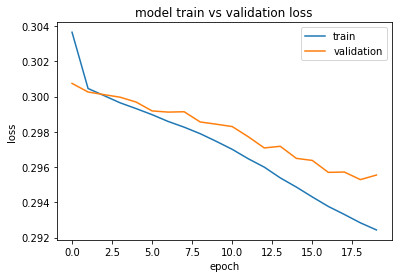

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [69]:
pred = model.predict(test_data)
pred[:10]

array([[0.47144163, 0.07386113, 0.30553943, 0.0351638 , 0.25168362,
        0.05912872],
       [0.47346342, 0.03860919, 0.20447263, 0.02283804, 0.20480874,
        0.0463993 ],
       [0.47552732, 0.03388829, 0.20244779, 0.02055536, 0.19882701,
        0.04633677],
       [0.49333158, 0.01922586, 0.24973284, 0.00863238, 0.20387083,
        0.02687917],
       [0.4746528 , 0.03680339, 0.21514474, 0.02227079, 0.20388126,
        0.04524364],
       [0.47396886, 0.02059631, 0.19594398, 0.01526903, 0.19589517,
        0.03966221],
       [0.4948608 , 0.01380996, 0.25529775, 0.00691031, 0.19996724,
        0.02368006],
       [0.48738515, 0.03282549, 0.20207301, 0.02037838, 0.1901139 ,
        0.04126344],
       [0.51686895, 0.02150333, 0.19607516, 0.02244844, 0.14712535,
        0.04031187],
       [0.47273123, 0.01807483, 0.17335708, 0.01584936, 0.18937089,
        0.04562315]], dtype=float32)